# PHÁT HIỆN VÀ PHÂN TÍCH CỘNG ĐỒNG
## Sử dụng thuật toán Louvain và Label Propagation

**Mục tiêu**: Phát hiện các cộng đồng (nhóm tác giả) trong mạng lưới đồng tác giả

**Thuật toán sử dụng**:
- **Louvain**: Tối ưu hóa modularity, phát hiện cộng đồng đa cấp
- **Label Propagation**: Nhanh, dựa trên lan truyền nhãn giữa các nodes

In [1]:
# Import thư viện
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import os
import pickle
from collections import Counter
import community as community_louvain  # python-louvain
from networkx.algorithms.community import label_propagation_communities
import warnings
warnings.filterwarnings('ignore')

# Thiết lập font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Đã import tất cả thư viện")

✓ Đã import tất cả thư viện


In [2]:
# Cấu hình
GRAPH_FILE = 'network_analysis_results/coauthor_graph.pkl'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
OUTPUT_DIR = f'community_analysis_results_{timestamp}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Thư mục kết quả: {OUTPUT_DIR}")

Thư mục kết quả: community_analysis_results_20251127_144324


In [3]:
# Load đồ thị
print("="*70)
print("LOAD DỮ LIỆU")
print("="*70)

with open(GRAPH_FILE, 'rb') as f:
    G = pickle.load(f)

print(f"\n✓ Đã load đồ thị")
print(f"  - Số nodes (tác giả): {G.number_of_nodes():,}")
print(f"  - Số edges (quan hệ đồng tác giả): {G.number_of_edges():,}")
print(f"  - Mật độ đồ thị: {nx.density(G):.6f}")

LOAD DỮ LIỆU

✓ Đã load đồ thị
  - Số nodes (tác giả): 166,314
  - Số edges (quan hệ đồng tác giả): 2,206,369
  - Mật độ đồ thị: 0.000160


---
## 1. THUẬT TOÁN LOUVAIN

**Đặc điểm**:
- Tối ưu hóa modularity (độ đo chất lượng phân chia cộng đồng)
- Phát hiện cộng đồng theo cấu trúc phân cấp
- Hiệu quả với đồ thị lớn

In [4]:
print("\n" + "="*70)
print("THUẬT TOÁN LOUVAIN")
print("="*70)

print("\nĐang phát hiện cộng đồng...")
louvain_communities = community_louvain.best_partition(G)
louvain_modularity = community_louvain.modularity(louvain_communities, G)
louvain_sizes = Counter(louvain_communities.values())

print(f"✓ Hoàn thành!\n")
print(f"KẾT QUẢ:")
print(f"  - Số lượng cộng đồng: {len(louvain_sizes):,}")
print(f"  - Modularity: {louvain_modularity:.4f}")
print(f"  - Kích thước lớn nhất: {max(louvain_sizes.values()):,} nodes")
print(f"  - Kích thước nhỏ nhất: {min(louvain_sizes.values()):,} nodes")
print(f"  - Kích thước trung bình: {np.mean(list(louvain_sizes.values())):.2f} nodes")
print(f"  - Kích thước trung vị: {np.median(list(louvain_sizes.values())):.0f} nodes")

print(f"\nTop 15 cộng đồng lớn nhất:")
for i, (comm_id, size) in enumerate(louvain_sizes.most_common(15), 1):
    percentage = (size / G.number_of_nodes()) * 100
    print(f"  {i:2d}. Cộng đồng {comm_id:4d}: {size:7,d} nodes ({percentage:5.2f}%)")


THUẬT TOÁN LOUVAIN

Đang phát hiện cộng đồng...
✓ Hoàn thành!

KẾT QUẢ:
  - Số lượng cộng đồng: 9,345
  - Modularity: 0.8230
  - Kích thước lớn nhất: 26,617 nodes
  - Kích thước nhỏ nhất: 1 nodes
  - Kích thước trung bình: 17.80 nodes
  - Kích thước trung vị: 3 nodes

Top 15 cộng đồng lớn nhất:
   1. Cộng đồng    3:  26,617 nodes (16.00%)
   2. Cộng đồng    2:   7,328 nodes ( 4.41%)
   3. Cộng đồng    7:   5,940 nodes ( 3.57%)
   4. Cộng đồng   24:   4,687 nodes ( 2.82%)
   5. Cộng đồng   25:   4,503 nodes ( 2.71%)
   6. Cộng đồng   28:   3,218 nodes ( 1.93%)
   7. Cộng đồng   10:   3,102 nodes ( 1.87%)
   8. Cộng đồng   19:   3,052 nodes ( 1.84%)
   9. Cộng đồng   22:   2,887 nodes ( 1.74%)
  10. Cộng đồng  117:   2,843 nodes ( 1.71%)
  11. Cộng đồng   12:   2,739 nodes ( 1.65%)
  12. Cộng đồng   29:   2,687 nodes ( 1.62%)
  13. Cộng đồng    4:   2,397 nodes ( 1.44%)
  14. Cộng đồng   54:   2,377 nodes ( 1.43%)
  15. Cộng đồng   92:   2,368 nodes ( 1.42%)


---
## 2. THUẬT TOÁN LABEL PROPAGATION

**Đặc điểm**:
- Mỗi node nhận nhãn từ láng giềng
- Rất nhanh, phù hợp với đồ thị lớn
- Kết quả có thể khác nhau mỗi lần chạy (do tính ngẫu nhiên)

In [5]:
print("\n" + "="*70)
print("THUẬT TOÁN LABEL PROPAGATION")
print("="*70)

print("\nĐang phát hiện cộng đồng...")
lp_communities_list = list(label_propagation_communities(G))

# Chuyển sang dictionary
lp_communities = {}
for comm_id, community in enumerate(lp_communities_list):
    for node in community:
        lp_communities[node] = comm_id

lp_modularity = nx.algorithms.community.modularity(G, lp_communities_list)
lp_sizes = Counter(lp_communities.values())

print(f"✓ Hoàn thành!\n")
print(f"KẾT QUẢ:")
print(f"  - Số lượng cộng đồng: {len(lp_sizes):,}")
print(f"  - Modularity: {lp_modularity:.4f}")
print(f"  - Kích thước lớn nhất: {max(lp_sizes.values()):,} nodes")
print(f"  - Kích thước nhỏ nhất: {min(lp_sizes.values()):,} nodes")
print(f"  - Kích thước trung bình: {np.mean(list(lp_sizes.values())):.2f} nodes")
print(f"  - Kích thước trung vị: {np.median(list(lp_sizes.values())):.0f} nodes")

print(f"\nTop 15 cộng đồng lớn nhất:")
for i, (comm_id, size) in enumerate(lp_sizes.most_common(15), 1):
    percentage = (size / G.number_of_nodes()) * 100
    print(f"  {i:2d}. Cộng đồng {comm_id:4d}: {size:7,d} nodes ({percentage:5.2f}%)")


THUẬT TOÁN LABEL PROPAGATION

Đang phát hiện cộng đồng...
✓ Hoàn thành!

KẾT QUẢ:
  - Số lượng cộng đồng: 20,469
  - Modularity: 0.7669
  - Kích thước lớn nhất: 1,507 nodes
  - Kích thước nhỏ nhất: 1 nodes
  - Kích thước trung bình: 8.13 nodes
  - Kích thước trung vị: 4 nodes

Top 15 cộng đồng lớn nhất:
   1. Cộng đồng    8:   1,507 nodes ( 0.91%)
   2. Cộng đồng   36:   1,360 nodes ( 0.82%)
   3. Cộng đồng  216:   1,242 nodes ( 0.75%)
   4. Cộng đồng  316:   1,218 nodes ( 0.73%)
   5. Cộng đồng   81:     786 nodes ( 0.47%)
   6. Cộng đồng  366:     786 nodes ( 0.47%)
   7. Cộng đồng  259:     567 nodes ( 0.34%)
   8. Cộng đồng  600:     558 nodes ( 0.34%)
   9. Cộng đồng  495:     372 nodes ( 0.22%)
  10. Cộng đồng    3:     359 nodes ( 0.22%)
  11. Cộng đồng  130:     357 nodes ( 0.21%)
  12. Cộng đồng  511:     337 nodes ( 0.20%)
  13. Cộng đồng  821:     333 nodes ( 0.20%)
  14. Cộng đồng  241:     310 nodes ( 0.19%)
  15. Cộng đồng  416:     310 nodes ( 0.19%)


---
## 3. LƯU KẾT QUẢ

In [6]:
# Lưu kết quả Louvain
print("\nĐang lưu kết quả Louvain...")

# Thêm thuộc tính vào đồ thị
G_louvain = G.copy()
for node, comm_id in louvain_communities.items():
    G_louvain.nodes[node]['louvain_community'] = comm_id

# Lưu GEXF
nx.write_gexf(G_louvain, f'{OUTPUT_DIR}/coauthor_graph_louvain.gexf')
print(f"✓ Đã lưu: {OUTPUT_DIR}/coauthor_graph_louvain.gexf")

# Lưu CSV chi tiết
louvain_data = []
for comm_id, size in louvain_sizes.most_common():
    members = [node for node, c in louvain_communities.items() if c == comm_id]
    louvain_data.append({
        'Community_ID': comm_id,
        'Size': size,
        'Percentage': (size / G.number_of_nodes()) * 100,
        'Sample_Members': ', '.join(str(m) for m in members[:10])
    })

df_louvain = pd.DataFrame(louvain_data)
df_louvain.to_csv(f'{OUTPUT_DIR}/louvain_communities.csv', index=False, encoding='utf-8-sig')
print(f"✓ Đã lưu: {OUTPUT_DIR}/louvain_communities.csv")


Đang lưu kết quả Louvain...
✓ Đã lưu: community_analysis_results_20251127_144324/coauthor_graph_louvain.gexf
✓ Đã lưu: community_analysis_results_20251127_144324/louvain_communities.csv


In [7]:
# Lưu kết quả Label Propagation
print("\nĐang lưu kết quả Label Propagation...")

G_lp = G.copy()
for node, comm_id in lp_communities.items():
    G_lp.nodes[node]['lp_community'] = comm_id

nx.write_gexf(G_lp, f'{OUTPUT_DIR}/coauthor_graph_label_propagation.gexf')
print(f"✓ Đã lưu: {OUTPUT_DIR}/coauthor_graph_label_propagation.gexf")

lp_data = []
for comm_id, size in lp_sizes.most_common():
    members = [node for node, c in lp_communities.items() if c == comm_id]
    lp_data.append({
        'Community_ID': comm_id,
        'Size': size,
        'Percentage': (size / G.number_of_nodes()) * 100,
        'Sample_Members': ', '.join(str(m) for m in members[:10])
    })

df_lp = pd.DataFrame(lp_data)
df_lp.to_csv(f'{OUTPUT_DIR}/label_propagation_communities.csv', index=False, encoding='utf-8-sig')
print(f"✓ Đã lưu: {OUTPUT_DIR}/label_propagation_communities.csv")


Đang lưu kết quả Label Propagation...
✓ Đã lưu: community_analysis_results_20251127_144324/coauthor_graph_label_propagation.gexf
✓ Đã lưu: community_analysis_results_20251127_144324/label_propagation_communities.csv


---
## 4. BIỂU ĐỒ MINH HỌA


Đang tạo biểu đồ Louvain...
✓ Đã lưu: community_analysis_results_20251127_144324/louvain_analysis.png


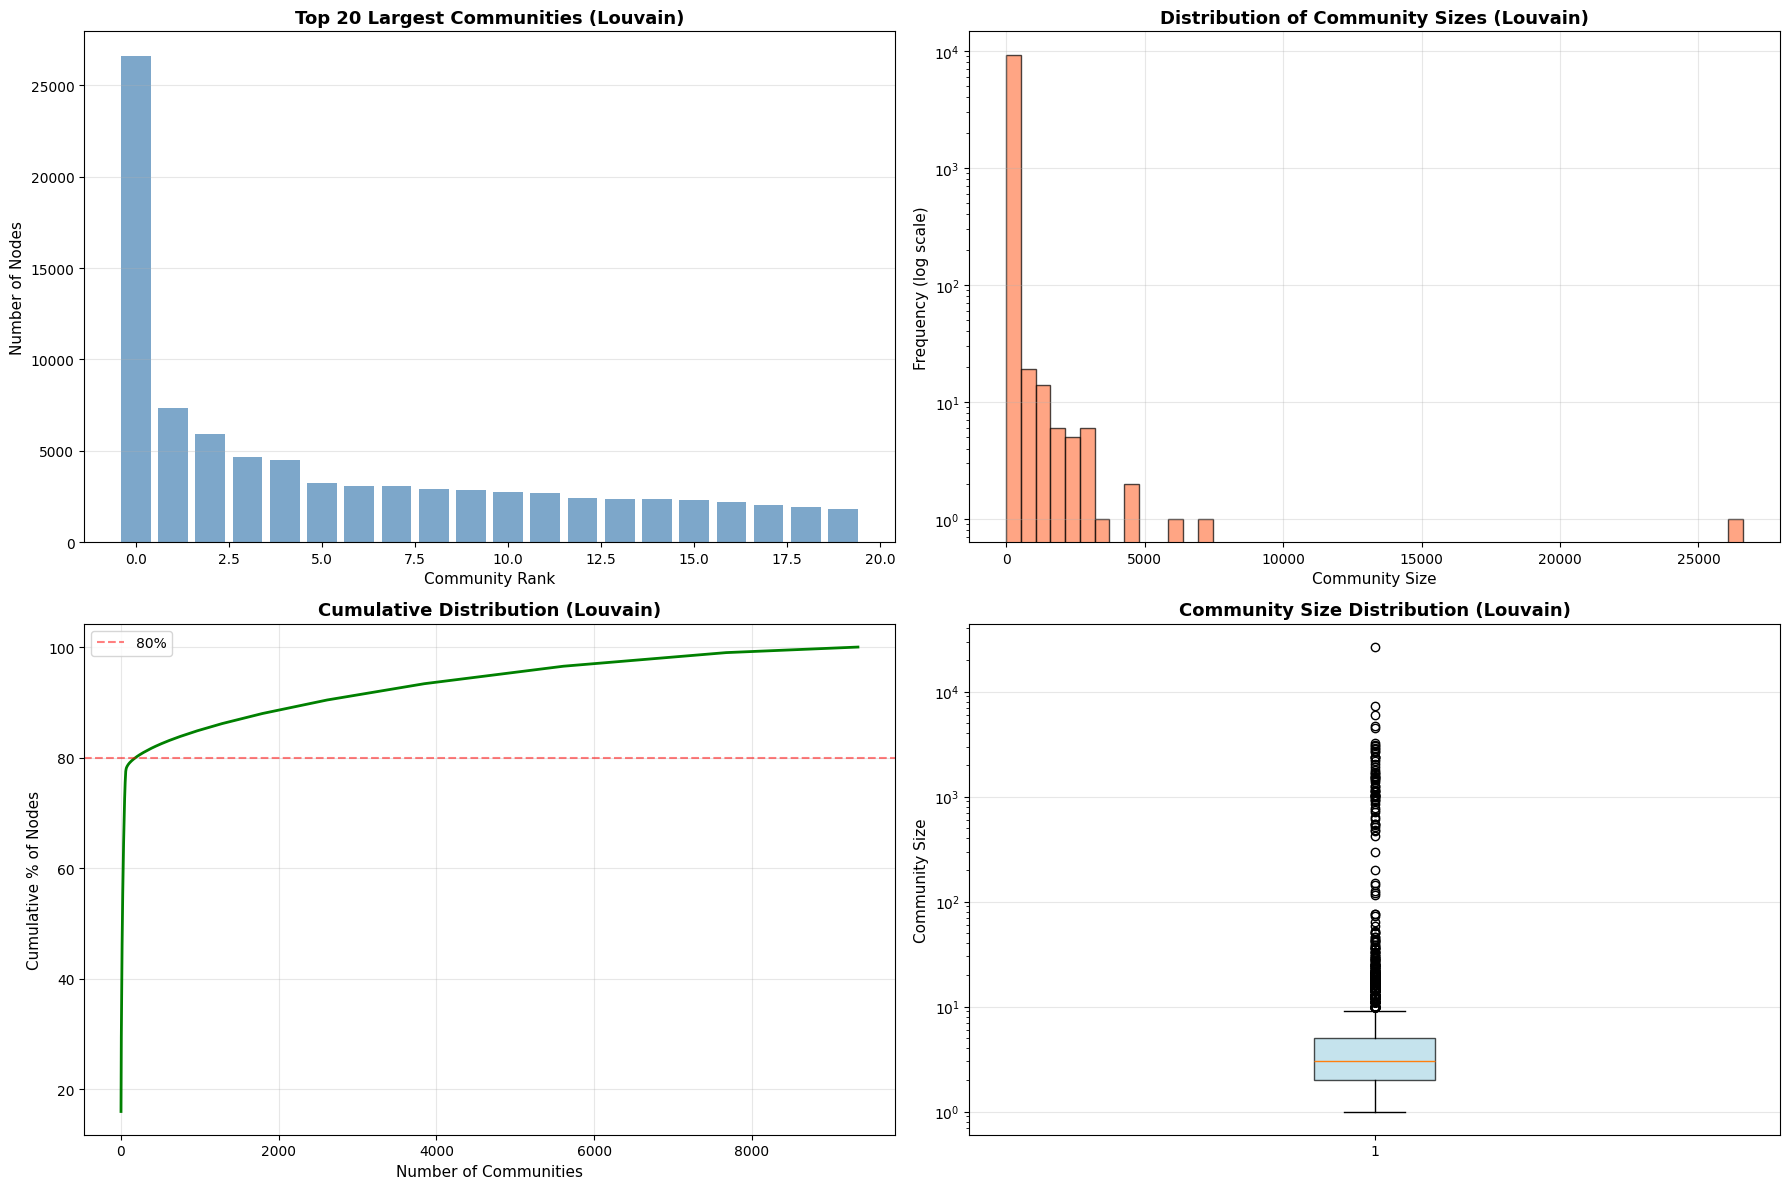

In [8]:
# Biểu đồ Louvain
print("\nĐang tạo biểu đồ Louvain...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top 20 cộng đồng lớn nhất
top_20 = louvain_sizes.most_common(20)
axes[0, 0].bar(range(len(top_20)), [c[1] for c in top_20], color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Community Rank', fontsize=11)
axes[0, 0].set_ylabel('Number of Nodes', fontsize=11)
axes[0, 0].set_title('Top 20 Largest Communities (Louvain)', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Phân phối kích thước (histogram)
all_sizes = list(louvain_sizes.values())
axes[0, 1].hist(all_sizes, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Community Size', fontsize=11)
axes[0, 1].set_ylabel('Frequency (log scale)', fontsize=11)
axes[0, 1].set_title('Distribution of Community Sizes (Louvain)', fontsize=13, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(alpha=0.3)

# 3. Cumulative distribution
sorted_sizes = sorted(all_sizes, reverse=True)
cumsum = np.cumsum(sorted_sizes)
cumsum_pct = (cumsum / G.number_of_nodes()) * 100
axes[1, 0].plot(range(len(cumsum_pct)), cumsum_pct, color='green', linewidth=2)
axes[1, 0].set_xlabel('Number of Communities', fontsize=11)
axes[1, 0].set_ylabel('Cumulative % of Nodes', fontsize=11)
axes[1, 0].set_title('Cumulative Distribution (Louvain)', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80%')
axes[1, 0].legend()

# 4. Box plot
axes[1, 1].boxplot([all_sizes], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1, 1].set_ylabel('Community Size', fontsize=11)
axes[1, 1].set_title('Community Size Distribution (Louvain)', fontsize=13, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/louvain_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Đã lưu: {OUTPUT_DIR}/louvain_analysis.png")
plt.show()


Đang tạo biểu đồ Label Propagation...
✓ Đã lưu: community_analysis_results_20251127_144324/label_propagation_analysis.png


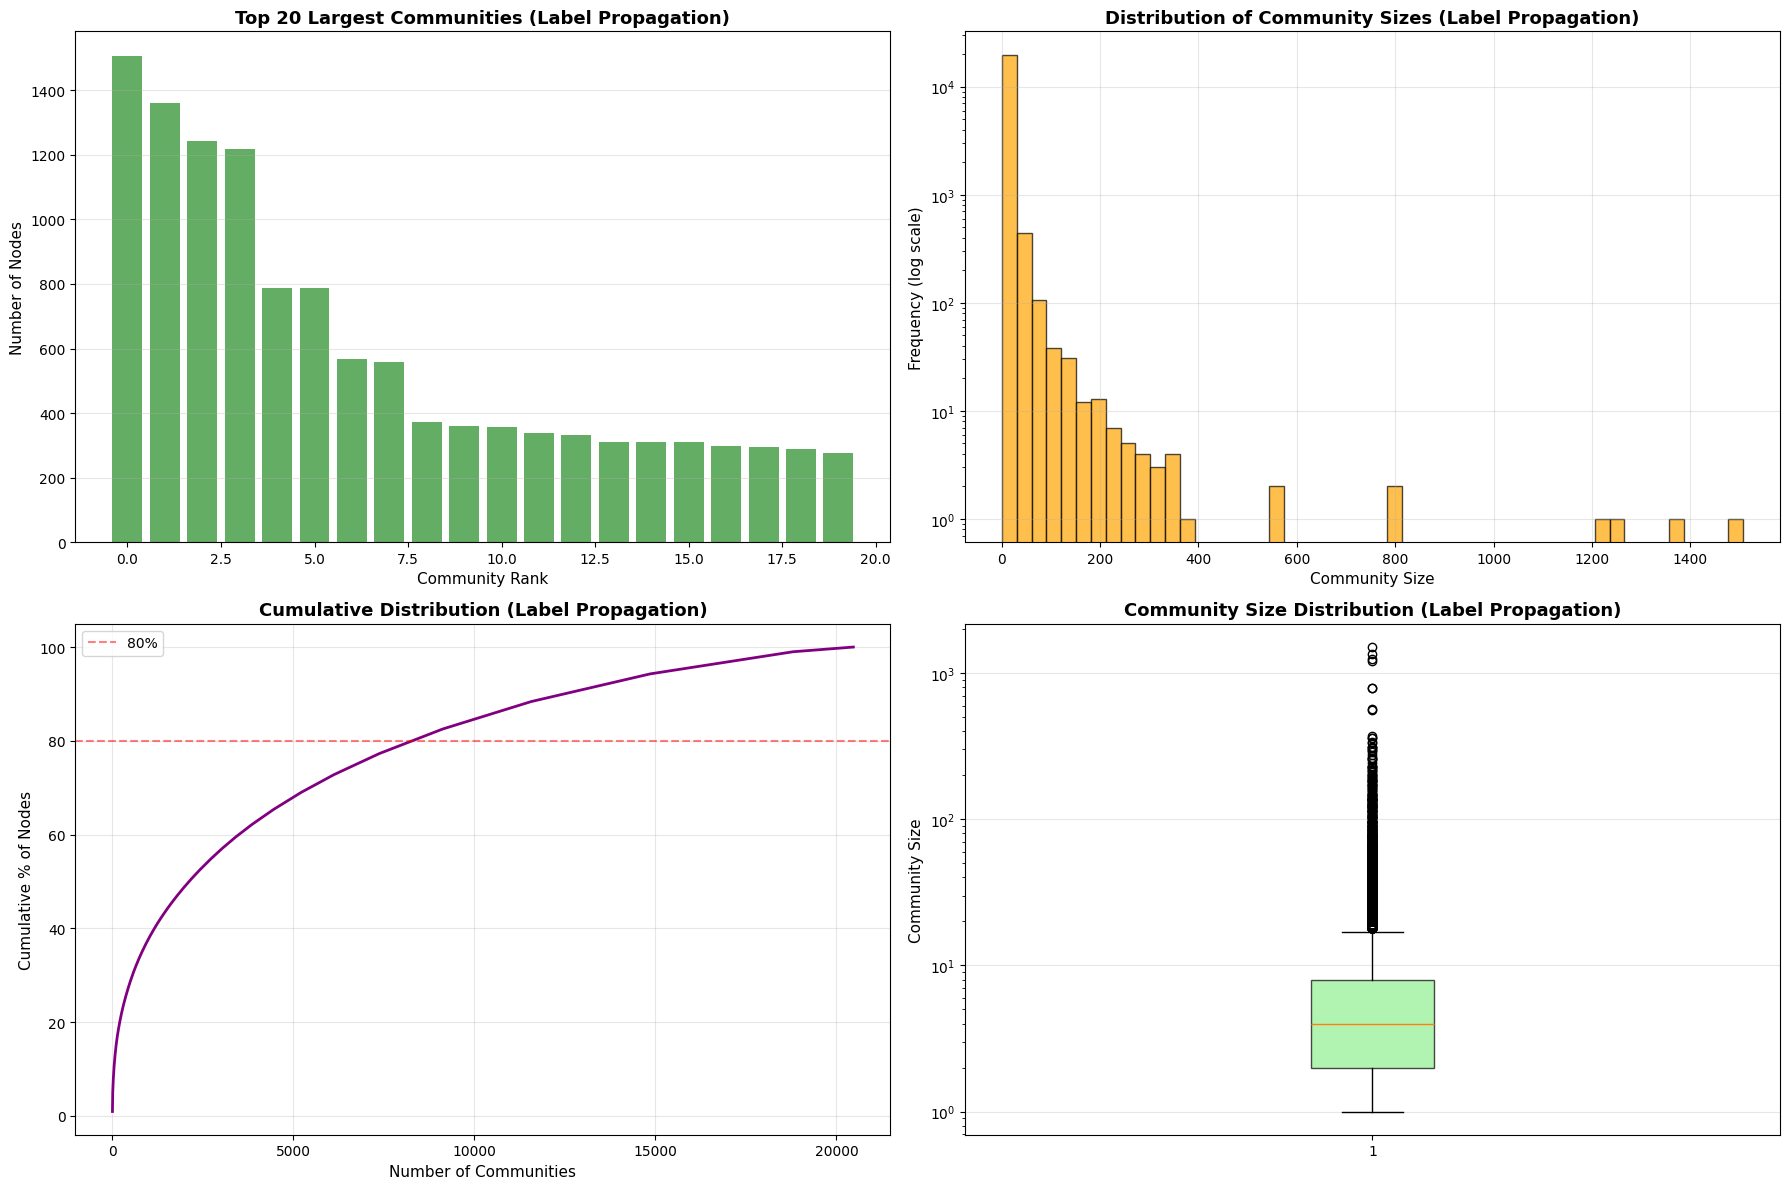

In [9]:
# Biểu đồ Label Propagation
print("\nĐang tạo biểu đồ Label Propagation...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top 20
top_20_lp = lp_sizes.most_common(20)
axes[0, 0].bar(range(len(top_20_lp)), [c[1] for c in top_20_lp], color='forestgreen', alpha=0.7)
axes[ 0, 0].set_xlabel('Community Rank', fontsize=11)
axes[0, 0].set_ylabel('Number of Nodes', fontsize=11)
axes[0, 0].set_title('Top 20 Largest Communities (Label Propagation)', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Histogram
all_sizes_lp = list(lp_sizes.values())
axes[0, 1].hist(all_sizes_lp, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Community Size', fontsize=11)
axes[0, 1].set_ylabel('Frequency (log scale)', fontsize=11)
axes[0, 1].set_title('Distribution of Community Sizes (Label Propagation)', fontsize=13, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(alpha=0.3)

# 3. Cumulative
sorted_sizes_lp = sorted(all_sizes_lp, reverse=True)
cumsum_lp = np.cumsum(sorted_sizes_lp)
cumsum_pct_lp = (cumsum_lp / G.number_of_nodes()) * 100
axes[1, 0].plot(range(len(cumsum_pct_lp)), cumsum_pct_lp, color='purple', linewidth=2)
axes[1, 0].set_xlabel('Number of Communities', fontsize=11)
axes[1, 0].set_ylabel('Cumulative % of Nodes', fontsize=11)
axes[1, 0].set_title('Cumulative Distribution (Label Propagation)', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80%')
axes[1, 0].legend()

# 4. Box plot
axes[1, 1].boxplot([all_sizes_lp], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7))
axes[1, 1].set_ylabel('Community Size', fontsize=11)
axes[1, 1].set_title('Community Size Distribution (Label Propagation)', fontsize=13, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/label_propagation_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Đã lưu: {OUTPUT_DIR}/label_propagation_analysis.png")
plt.show()